# Comparing Geneformer & UCE for cell-type classification

One known downstream application of RNA foundation models is cell-type classification. However, it is not always easy to know which foundation model will perform best and working with different bio foundation models is time consuming. With the Helical package, we have streamlined this task and made foundation models interchangaeble.

In the example notebook, we levarge Helical to compare two leading RNA foundation models: Geneformer and UCE. We show you how to use these models for classifying cell types and evaluate them on a labelled data set.
It also serves a template on to use those models in a standardised way in your own applications.

### Geneformer
Geneformer is a foundation transformer model pretrained on Genecorpus-30M, a corpus comprised of ~30 million single cell transcriptomes from a broad range of human tissues. Each single cell’s transcriptome is presented to the model as a rank value encoding where genes are ranked by their expression in that cell normalized by their expression across the entire Genecorpus-30M. Geneformer displays both zero-shot capabilities as well as fine-tuning tasks relevant to chromatin and network dynamics.
- 📄 [Paper](https://www.nature.com/articles/s41586-023-06139-9): The paper that made it into Nature!

### UCE
The Universal Cell Embedding (UCE) model creates a universal biological representation space for cells, leveraging a self-supervised learning approach on cell atlas data from diverse species (which is a key differentiator from geneformer, trained on human data). UCE creates an atlas of over 36 million cells, with more than 1,000 uniquely named cell types, from hundreds of experiments, dozens of tissues and eight species. It captures significant biological variations and enables mapping of any cell to this embedding without further model adjustments.
- 📄 [Paper](https://www.biorxiv.org/content/10.1101/2023.11.28.568918v1)
- 💽 [GitHub](https://github.com/snap-stanford/UCE)


### 🧬 About Helical:
Helical provides an open-source framework for and gathers state-of-the-art pre-trained genomics and transciptomics bio foundation models. Still work in progress, but we look forward to interacting with the community to build meaningful things. You can directly reach us:
- support@helical-ai.com (slack-channel incoming). We answer within hours! Reach out if you have questions, ideas, improvement suggestions, colab, ...
- [Github](https://github.com/helicalAI/helical-package/issues). On our github in the issue section 


### Before you start
Be sure to install the Helical python package as descibed in [Installation](https://github.com/helicalAI/helical-package).

## 1) Imports 
Let's start by importing all the packages used in this notebook

In [ ]:
try:
    import helical
except:
    !pip install --ignore-installed git+https://github.com/helicalAI/helical.git@develop_notebooks_ma |tail -n 1
    !pip install numpy==1.23.5
    import helical

In [185]:
import anndata as ad
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd
import logging
import requests


logging.getLogger().setLevel(logging.WARNING)

warnings.filterwarnings("ignore")

# Import Geneformer & UCE from the Helical package
from helical.models.geneformer.model import Geneformer,GeneformerConfig
from helical.models.uce.model import UCE,UCEConfig

## 2) Dataset loading and Splitting

The data set is a subset of the human PBMC, comprising 54,760 training cells and 13,690 test cells, with 16,906 genes across 11 distinct cell types. It is great for benchmarking due to its class imbalance. We will pretend not to have labels for the main cell-type classification, but leverage the existing labels to evaluate the performance of the algorithms.

The following cell checks if you already have the file in the folder. if not, it automatically downloads the file.

Let's start by running the command below to download the data set automatically (this could take a few seconds):

In [188]:
url = "https://helicalpackage.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad"

# Extract the filename and download the file
filename = url.split("/")[-1]

# Check if the file already exists in the current directory
if os.path.exists(filename):
    print(f"Files already exist. Skipping downloads.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}.")

Files already exist. Skipping downloads.


We split the data in a train

In [190]:
ann_data = ad.read_h5ad("10k_pbmcs_proc.h5ad")
#Split the data set into a training and test set to evluate results down-the-line.
X_train, X_test = train_test_split(ann_data,train_size=0.01,test_size=0.005,random_state=0)

## 3) Zero Shot prediction with Geneformer

### 3.1) Model training and inference

The first time you execute the cell below, the model weights will be downloaded automatically, this could take a few seconds:

In [194]:
model_config = GeneformerConfig(batch_size=5,device='cuda')   
geneformer = Geneformer(configurer=model_config)

In [195]:
# The "process_data"-function from the Helical package pre-processes the data. 
# It takes AnnData as an input. 
# More information in our documentation
train_dataset = geneformer.process_data(X_train,nproc=1)
test_dataset = geneformer.process_data(X_test,nproc=1)

Creating dataset.


Map (num_proc=4):   0%|          | 0/119 [00:00<?, ? examples/s]

Creating dataset.


Map (num_proc=4):   0%|          | 0/60 [00:00<?, ? examples/s]

In [196]:
ref_embeddings = geneformer.get_embeddings(train_dataset)
test_embeddings = geneformer.get_embeddings(test_dataset)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

### 3.2) Visualization with UMAP
Let's visualize the embeddings leveraging UMAP. The idea is simple: can we identify clusters of cells that the models considers as being similar enough to put them close in space ? If this hypothesis happens to be true, the models can be used to infer cell types based on a few hand-labelled cells!

In the cell below, we plot our outputs once without labels and onc with the labels from our dataset (which in a real-world setup would of course not be available).

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

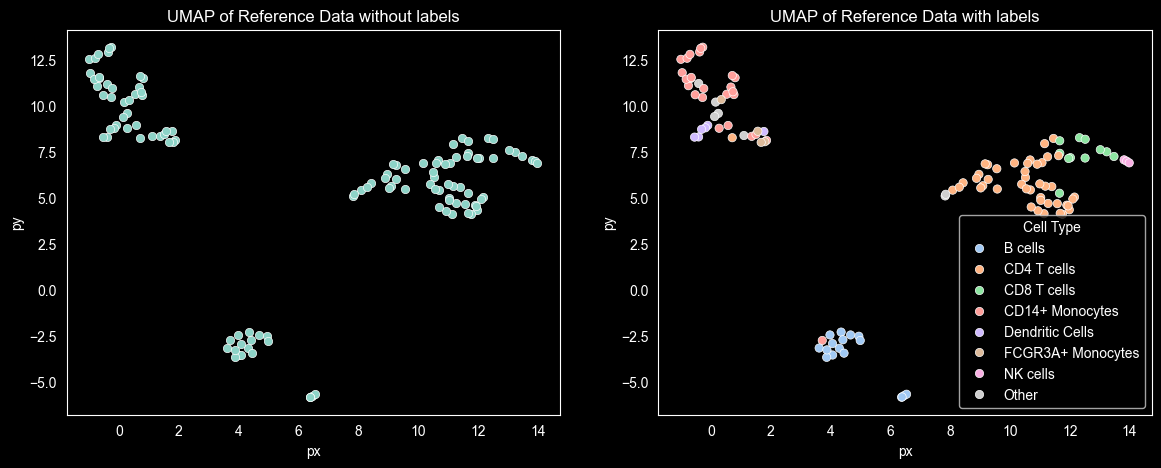

In [198]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(ref_embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = X_train.obs['cell_type']
plot_df['Cell Type'] = labels.values


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

This looks great! Geneformer seems to be capable to cluster cells according to their cell type. Let's explore how we can leverage this capability to infer cell types on an unlabelled data set.

## 4) Prediction: Leverage your hand-labelled cells to predict label of other cells

We can use a K-Neirhbours classifier to predict cell types on an unlabelled data set. We have separated our data set into a train and test set. Let's use the train set to train a classifier and predict labels on the "unseen" test set. We can then use the labels in this test set to evaluate how accurate our prediction was.

In [202]:
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

KNeighborsClassifier(metric='cosine')

In [203]:
pred_labels = neigh.predict(test_embeddings)

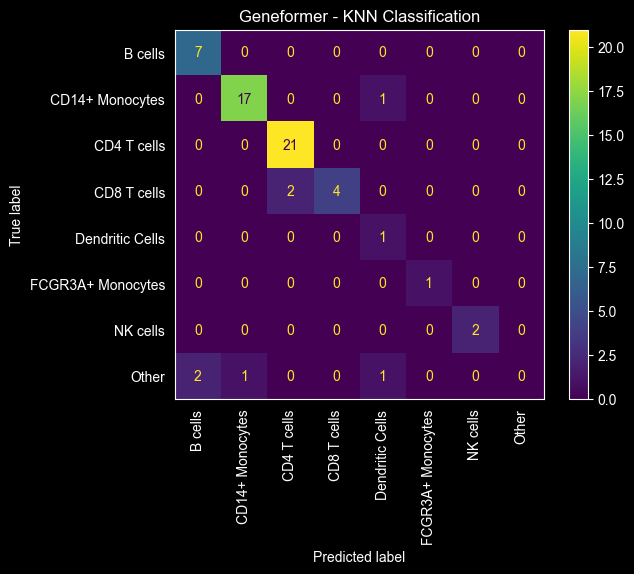

In [204]:
cm_geneformer = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_geneformer, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()

In [205]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       0.78      1.00      0.88         7
  CD14+ Monocytes       0.94      0.94      0.94        18
      CD4 T cells       0.91      1.00      0.95        21
      CD8 T cells       1.00      0.67      0.80         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       0.00      0.00      0.00         4

         accuracy                           0.88        60
        macro avg       0.75      0.83      0.76        60
     weighted avg       0.85      0.88      0.86        60



## 4) Zero Shot prediction with UCE

Let's do the same with UCE so we can compare the performance!

### Model training and inference
Let's load the model weights of UCE (keep in mind that UCE is a large model and downloading the weights will take approximately 10 minutes - make sure to keep your pc open during this time).

In [209]:
model_config = UCEConfig(batch_size=5)
uce = UCE(configurer=model_config)

In [210]:
train_data = uce.process_data(X_train)
ref_embeddings = uce.get_embeddings(train_data)

100%|██████████| 24/24 [00:36<00:00,  1.50s/it]


### Visualization with UMAP

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

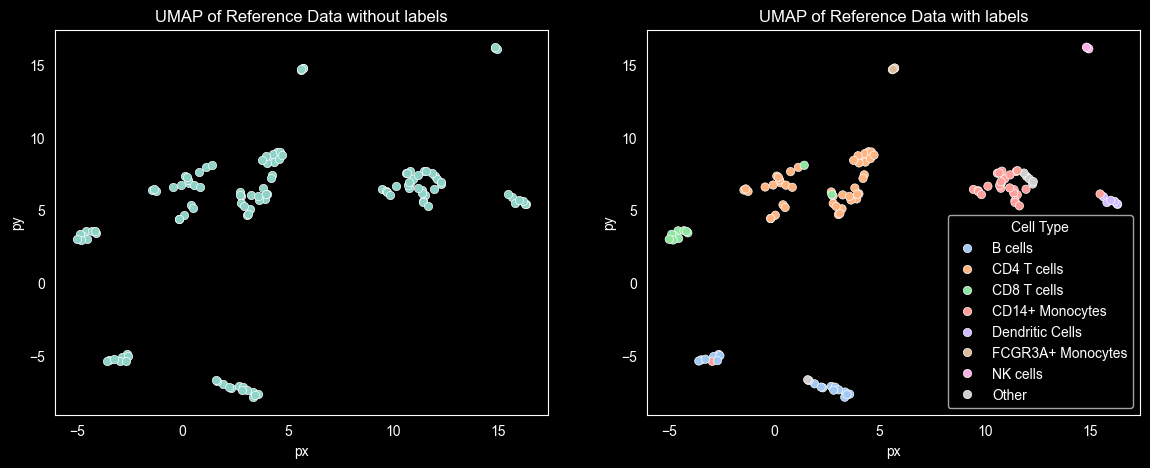

In [212]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

### Evaluation: k-nearest neighbors

In [214]:
test_data = uce.process_data(X_test)
test_embeddings = uce.get_embeddings(test_data)

100%|██████████| 12/12 [00:17<00:00,  1.50s/it]


In [215]:
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

pred_labels = neigh.predict(test_embeddings)

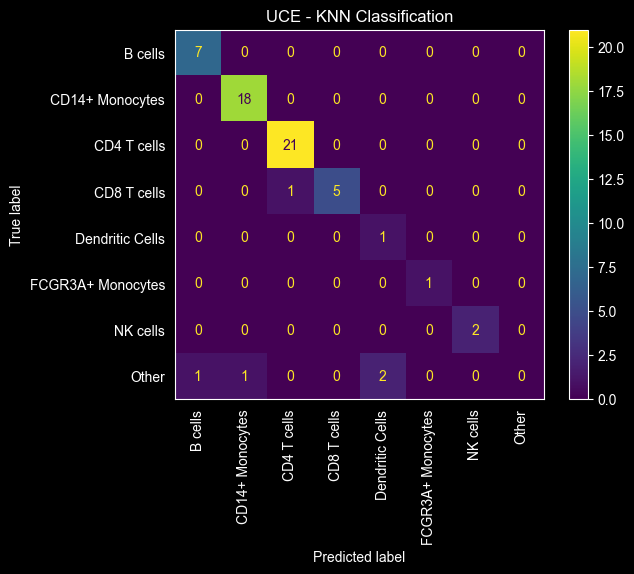

In [216]:
cm_UCE = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_UCE, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("UCE - KNN Classification")
plt.show()

In [217]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       0.88      1.00      0.93         7
  CD14+ Monocytes       0.95      1.00      0.97        18
      CD4 T cells       0.95      1.00      0.98        21
      CD8 T cells       1.00      0.83      0.91         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       0.00      0.00      0.00         4

         accuracy                           0.92        60
        macro avg       0.76      0.85      0.79        60
     weighted avg       0.88      0.92      0.89        60



## 5) Compare Results - Who's better ?
Now, who is better ? which model should you use for your cell classification task ? Let's put the results next to each other to compare:

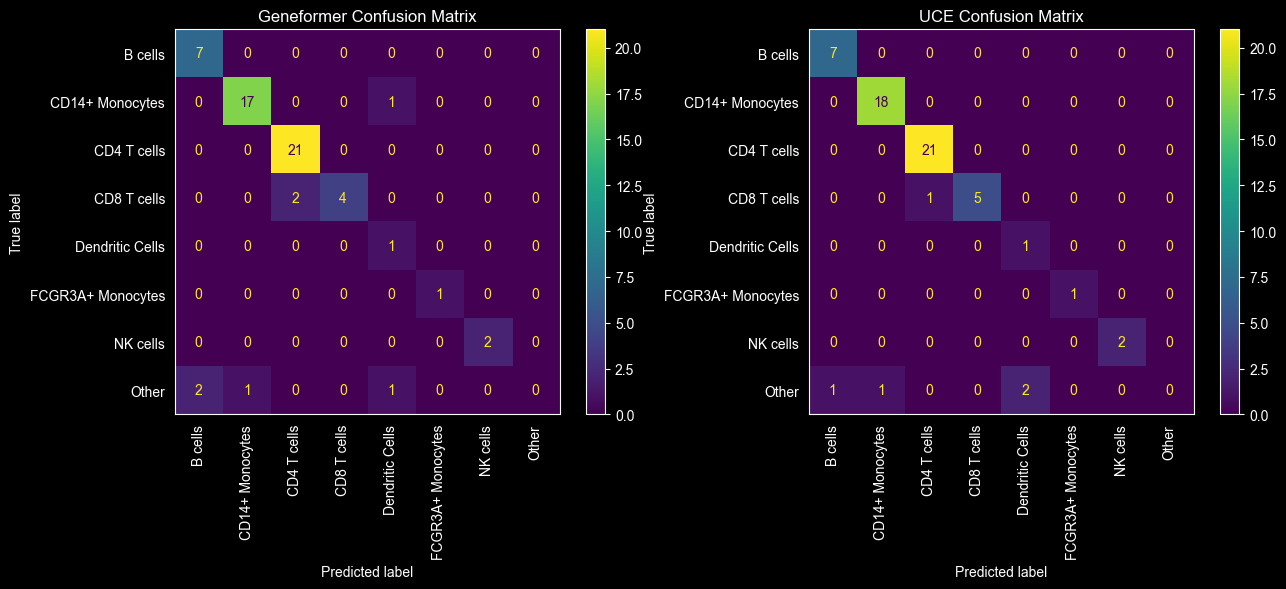

In [248]:
# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_geneformer, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical",ax=axs[0])
axs[0].set_title('Geneformer Confusion Matrix')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_UCE, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical",ax=axs[1])
axs[1].set_title('UCE Confusion Matrix')

plt.show()

Close enough. 

Both show good performances in terms of counts. 
It would be interesting to test this on your own data and extend this script to other models (we recently have added scGPT, try it out !).

## What's next ?
Stay tuned, we will add the most relevant RNA foundation models to Helical (and other modalities).

If you have a use case in mind that we should look at, some feedback to share, or you just want to have a chat, please reach out (support@helical-ai.com), we will get back to you really quickly :)